## CS 4795 Final Project

***
`PREPARING THE MODEL`
***

In [28]:
import torch

has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cpu"
# device = "cpu"

print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

MPS (Apple Metal) is AVAILABLE
Target device is mps


In [29]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
# import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [31]:
# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [32]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [33]:
# Network

class CNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16*7*7, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        h = x
        x = self.fc1(x)

        return x, h

In [79]:
# Initialize model
model = CNN().to(device)

In [80]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

***
`TRAINING THE MODEL`
***

In [81]:
num = int(60000/batch_size/5)

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    running_accuracy = 0.0

    print('Epoch:', epoch + 1, '\n')
    for batch, data in enumerate(train_loader):
        inputs = data[0].to(device=device)
        labels = data[1].to(device=device)

        optimizer.zero_grad()

        # forward
        outputs, _ = model(inputs)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward
        loss.backward()
        # gradient descent
        optimizer.step()
        
        if batch % num == num-1:
            avg_loss_across_batches = running_loss / num
            avg_acc_across_batches = (running_accuracy / num) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0.0
            running_accuracy = 0.0
    print('---------------------------------------------\n')

print("Done")

Epoch: 1 

Batch 187, Loss: 0.988, Accuracy: 71.4%
Batch 374, Loss: 0.282, Accuracy: 91.6%
Batch 561, Loss: 0.201, Accuracy: 94.2%
Batch 748, Loss: 0.153, Accuracy: 95.3%
Batch 935, Loss: 0.124, Accuracy: 96.3%
---------------------------------------------

Epoch: 2 

Batch 187, Loss: 0.105, Accuracy: 97.0%
Batch 374, Loss: 0.094, Accuracy: 97.2%
Batch 561, Loss: 0.084, Accuracy: 97.5%
Batch 748, Loss: 0.075, Accuracy: 97.9%
Batch 935, Loss: 0.080, Accuracy: 97.5%
---------------------------------------------

Epoch: 3 

Batch 187, Loss: 0.063, Accuracy: 98.1%
Batch 374, Loss: 0.073, Accuracy: 97.9%
Batch 561, Loss: 0.067, Accuracy: 98.0%
Batch 748, Loss: 0.064, Accuracy: 98.0%
Batch 935, Loss: 0.062, Accuracy: 98.1%
---------------------------------------------

Epoch: 4 

Batch 187, Loss: 0.056, Accuracy: 98.4%
Batch 374, Loss: 0.063, Accuracy: 98.1%
Batch 561, Loss: 0.057, Accuracy: 98.3%
Batch 748, Loss: 0.047, Accuracy: 98.5%
Batch 935, Loss: 0.057, Accuracy: 98.2%
---------------

***
`ACCURACY OF THE MODEL`
***

In [88]:
# Check accuracy of model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            # x = x.reshape(x.shape[0], -1)

            scores, _ = model(x)
            # loss = criterion(scores, y)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        # acc = float(num_correct) / float(num_samples)
        # print('Accuracy: ', acc)
        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct) / float(num_samples)*100:.2f}')
        # print('Loss:', loss)
    
    model.train()

In [89]:
check_accuracy(test_loader, model)

Got 9871/10000 with accuracy 98.71


***
`ANALYZING THE MODEL`
***

In [39]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [40]:
images, labels, probs = get_predictions(model, test_loader, device)

In [41]:
pred_labels = torch.argmax(probs, 1)

***
`CONFUSION MATRIX`
***

In [42]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

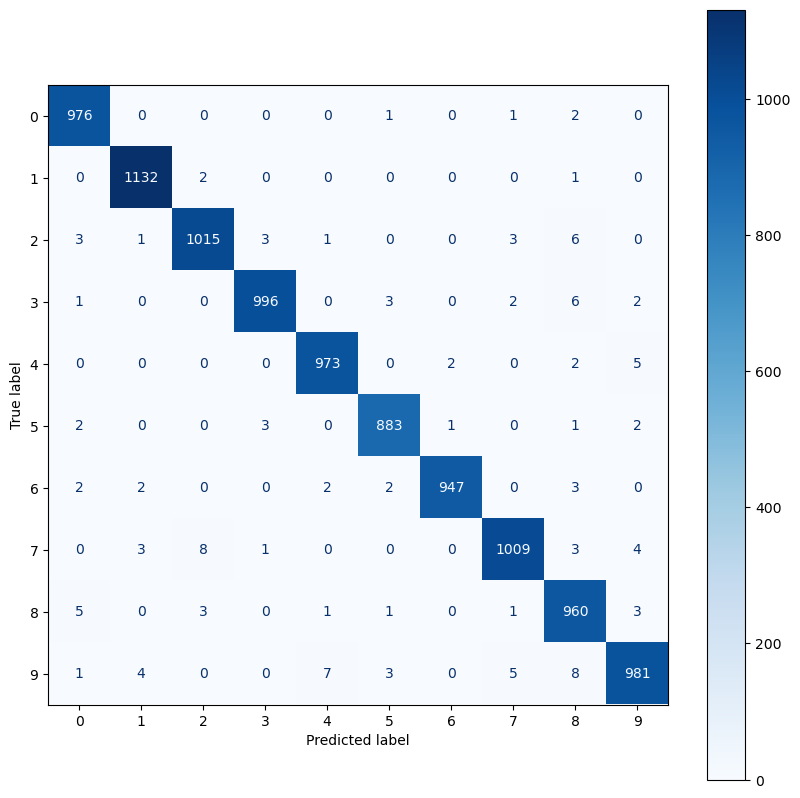

In [43]:
plot_confusion_matrix(labels, pred_labels)

***
`MOST INCORRECT GUESSES`
***

In [44]:
corrects = torch.eq(labels, pred_labels)

In [45]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [46]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

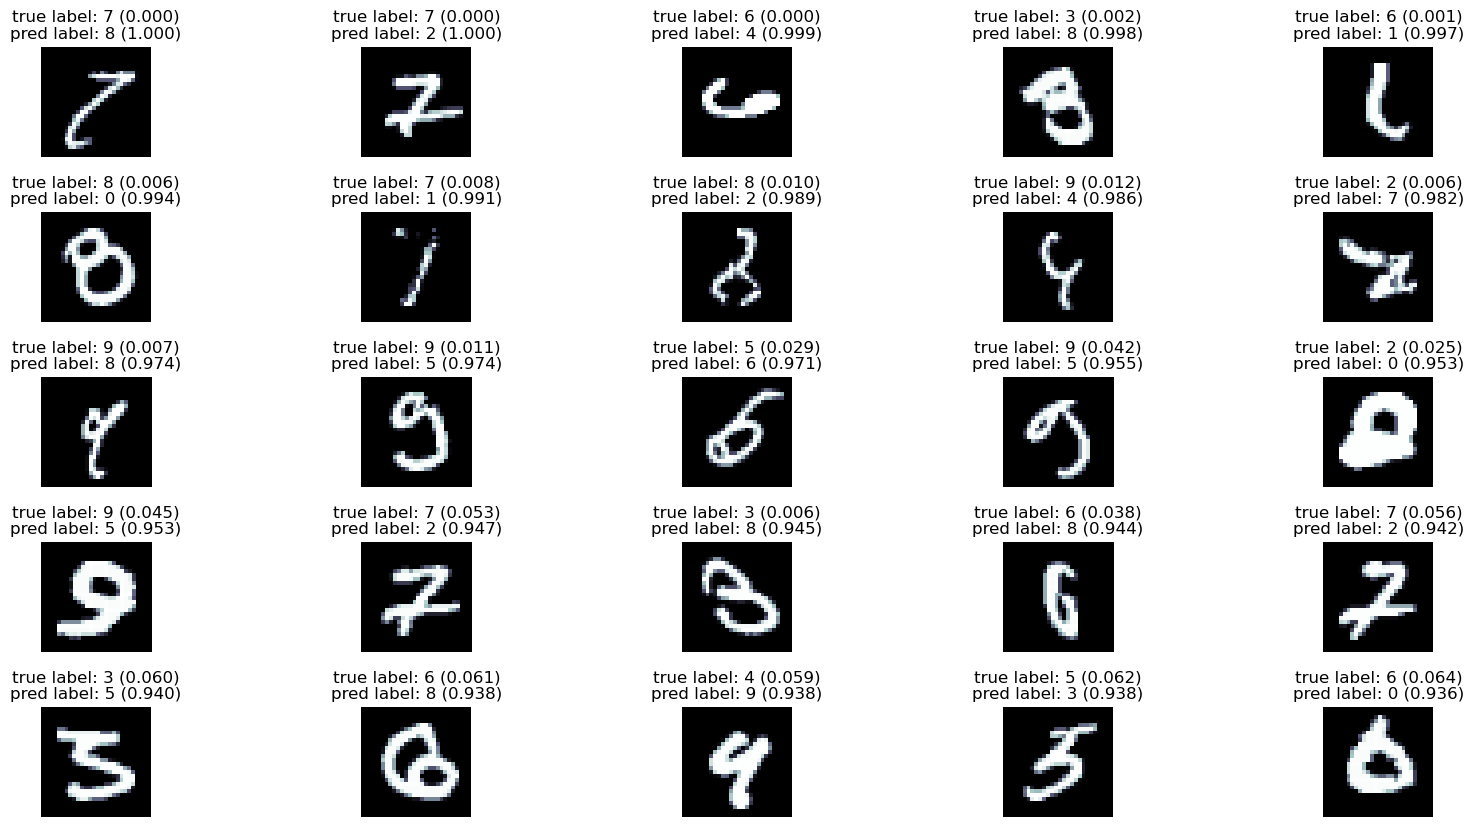

In [47]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

***
`LOWER DIMENSION VISUALIZATION`
***

In [48]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [49]:
outputs, intermediates, labels = get_representations(model,
                                                     train_loader,
                                                     device)

  0%|          | 0/938 [00:00<?, ?it/s]

***
`PCA PLOT`
***

In [50]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [51]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [52]:
output_pca_data = get_pca(outputs)

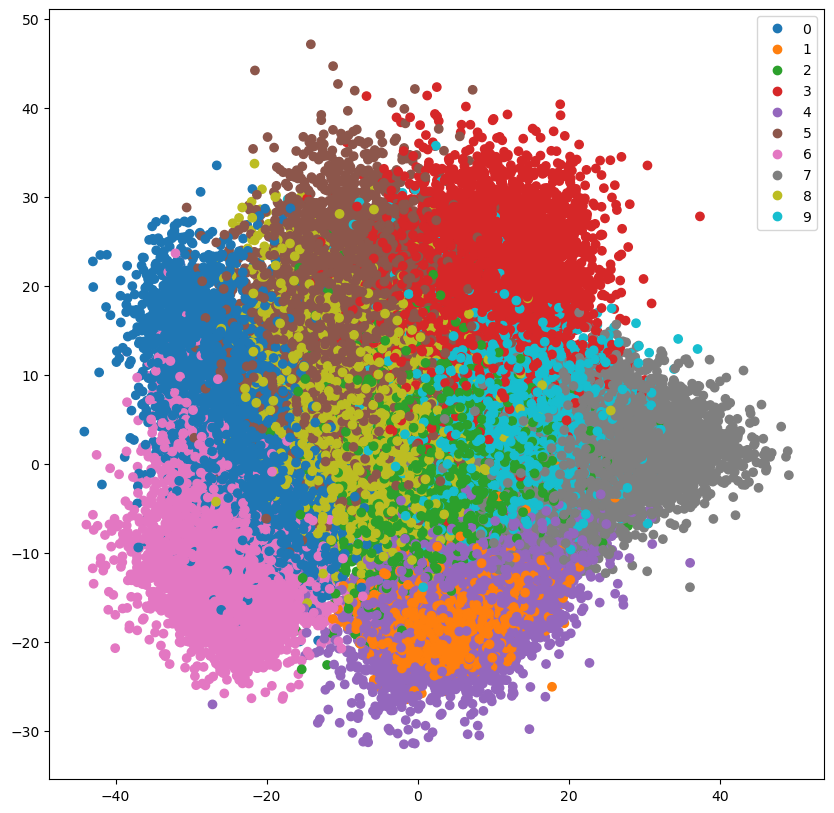

In [53]:
plot_representations(output_pca_data, labels)

Plotting the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

We can see that a lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense, as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

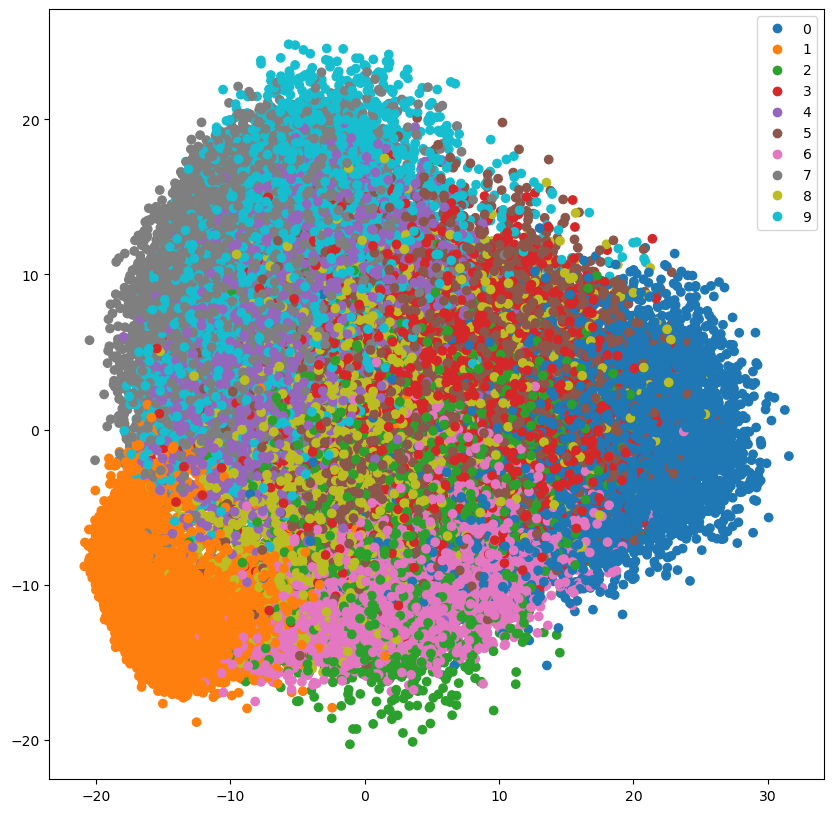

In [54]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

***
`t-SNE PLOT`
***

In [55]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

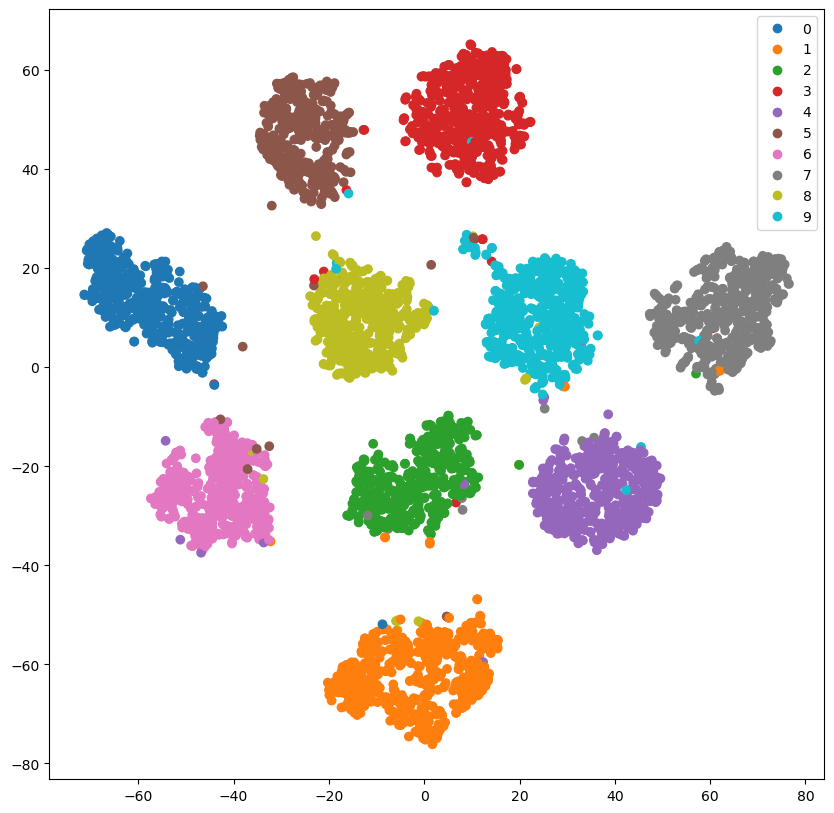

In [56]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Again, the intermediate representations are more clustered, which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

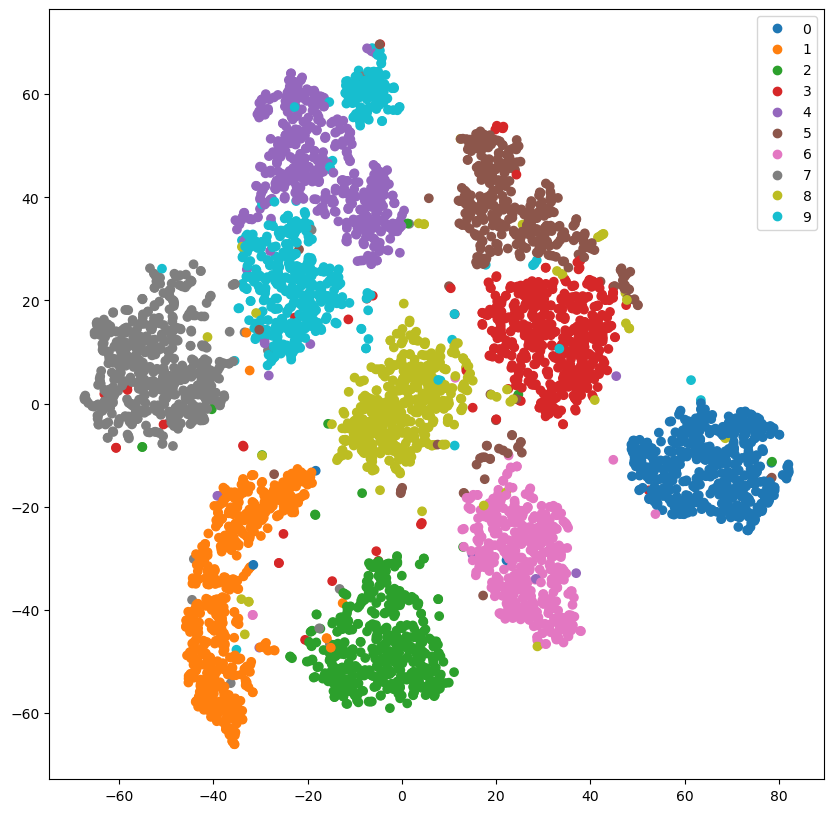

In [57]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

***
`FILTERS`
***

In [90]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

Some of our filters look for areas of black pixels, which has the effect of inverting our images. Some apply a blur effect, which is similar to [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) effects used in image processing to reduce noise in the image. Some detect edges, like our Sobel filters we created earlier.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly, and some filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give a better performance.

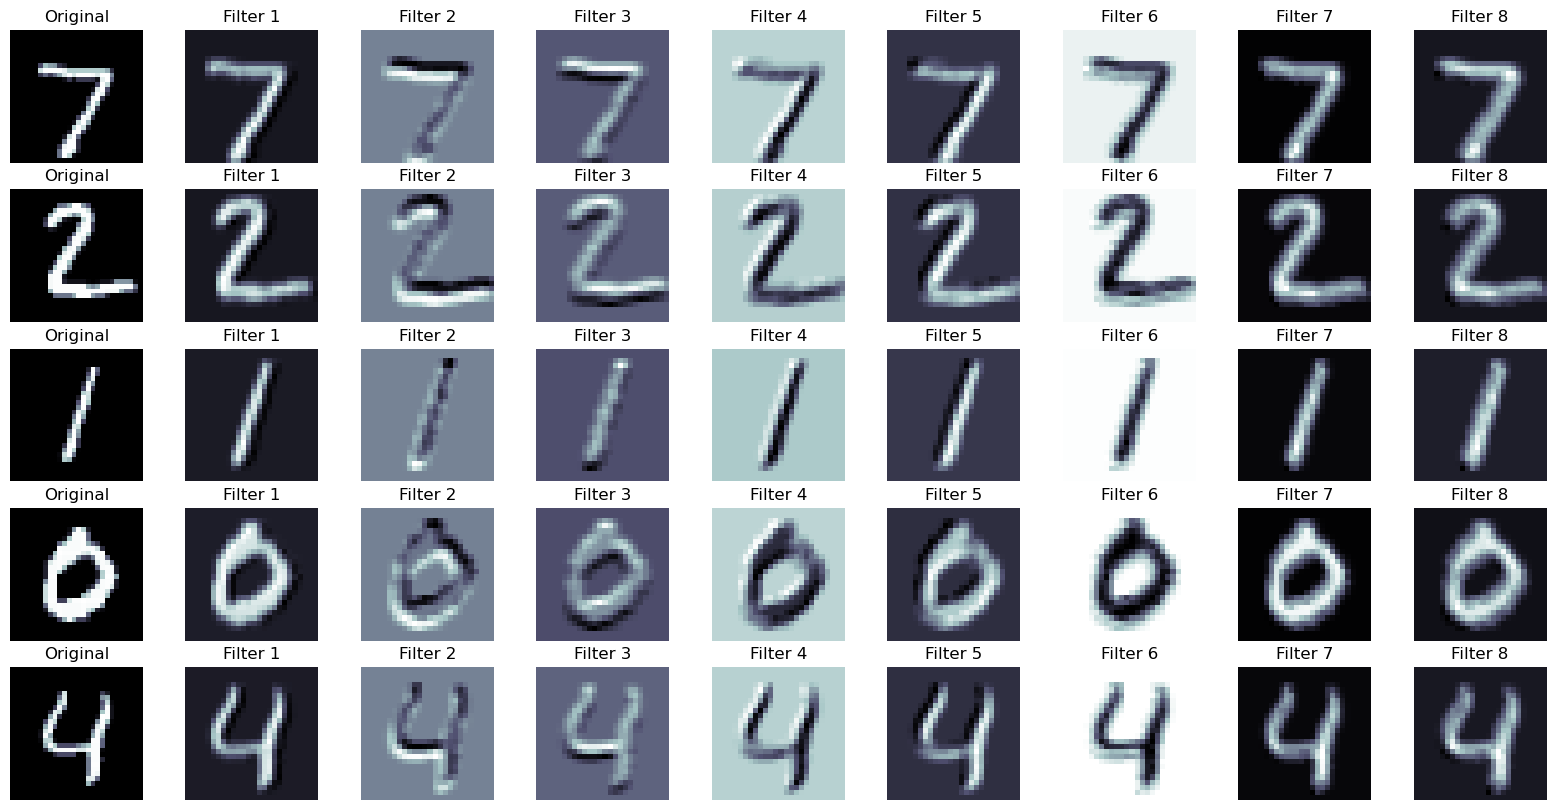

In [91]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

In [92]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

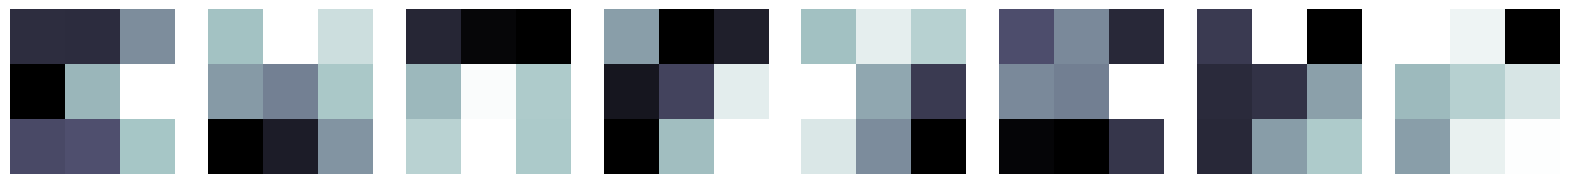

In [93]:
plot_filters(filters)

In [94]:
filters2 = model.conv2.weight.data

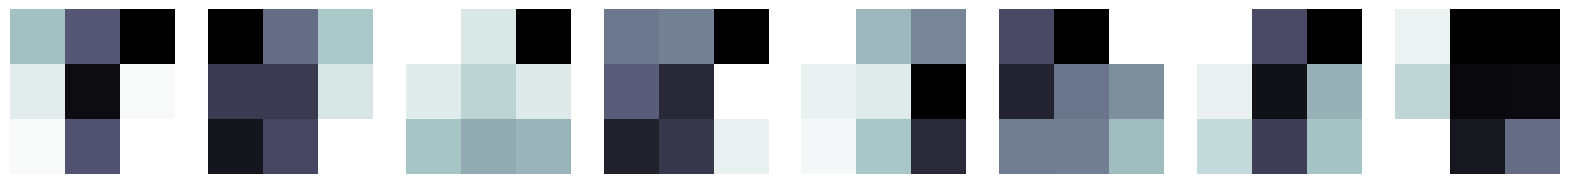

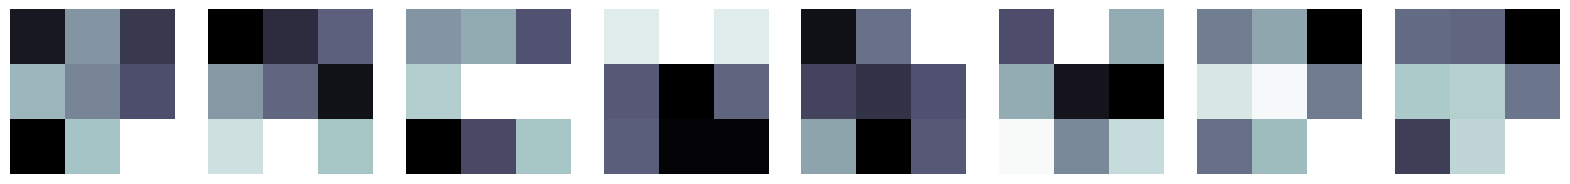

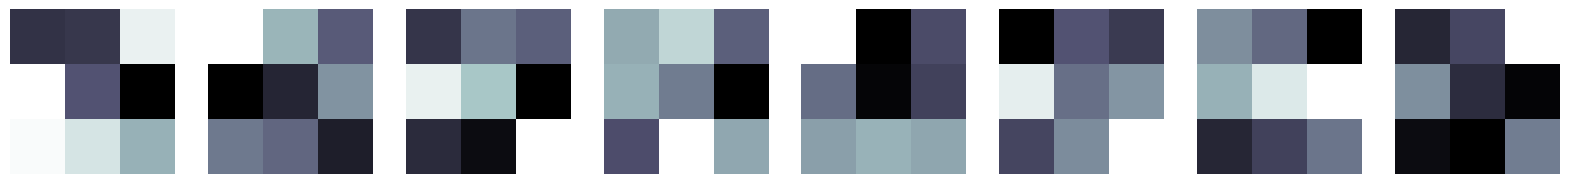

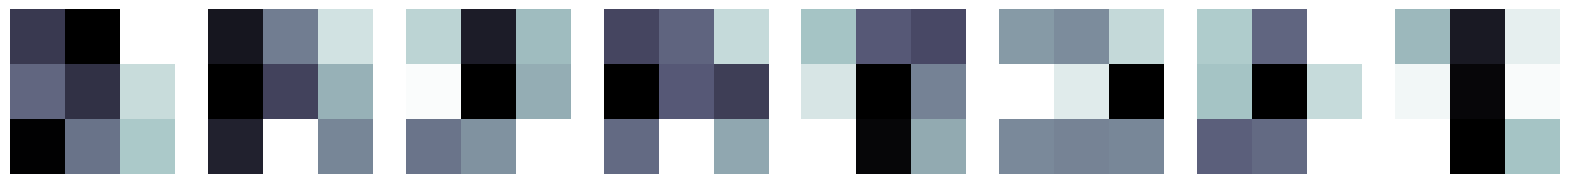

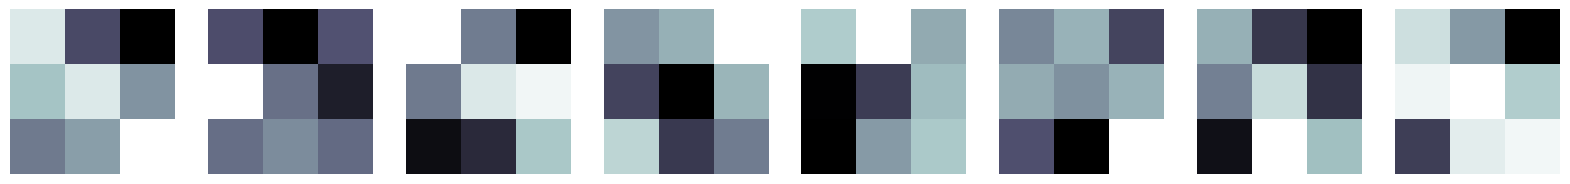

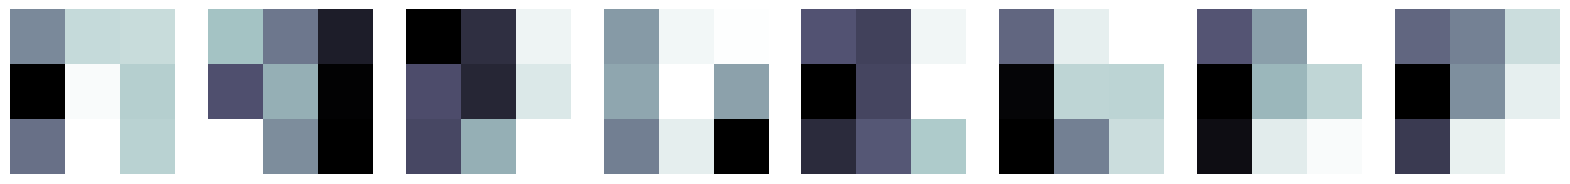

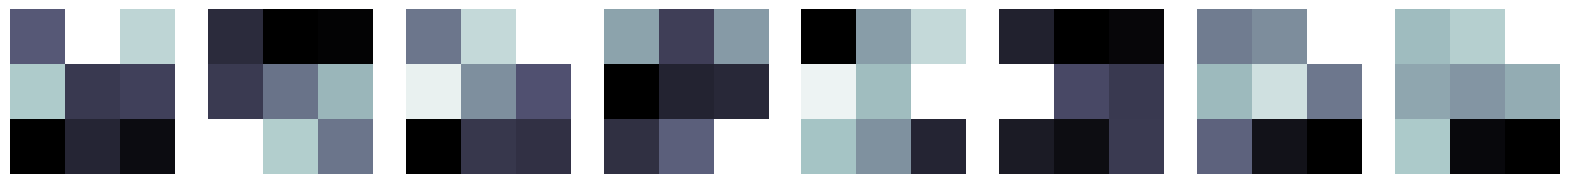

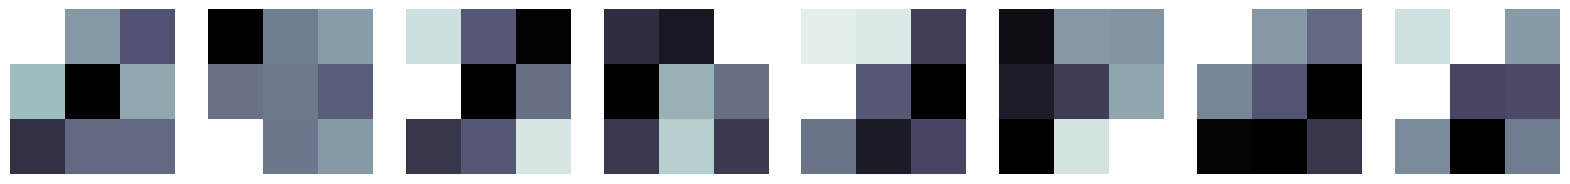

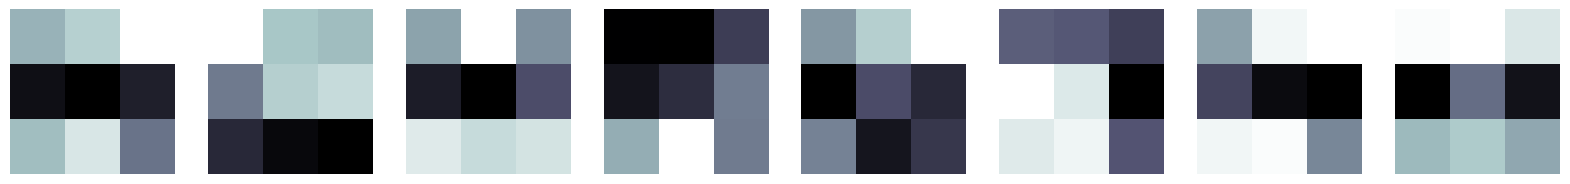

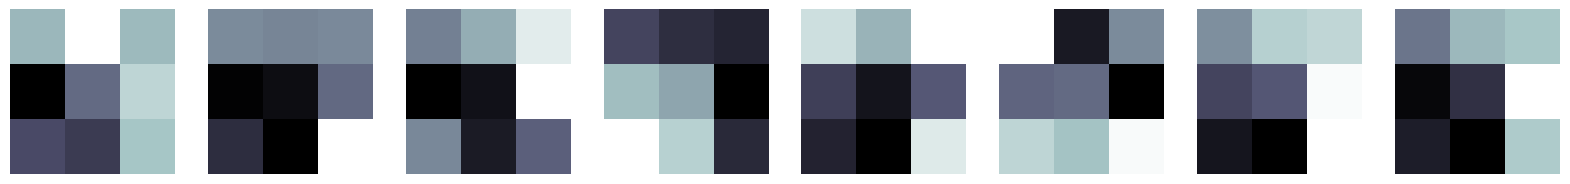

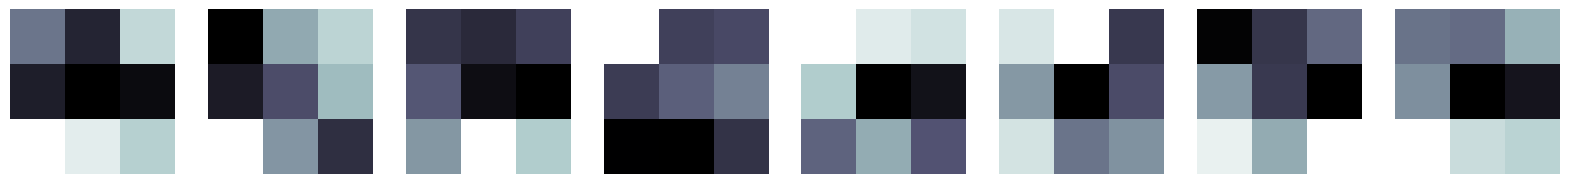

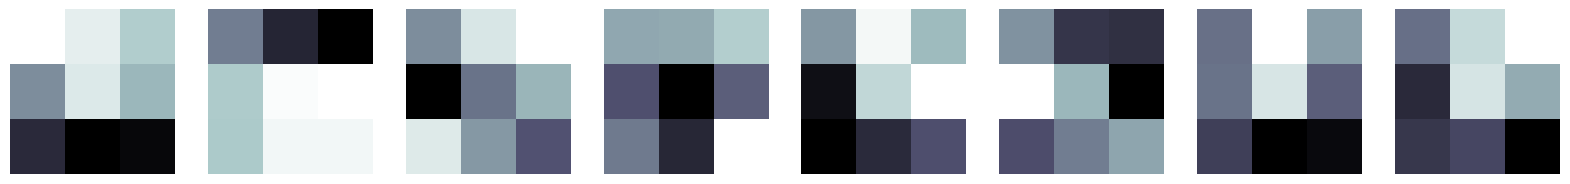

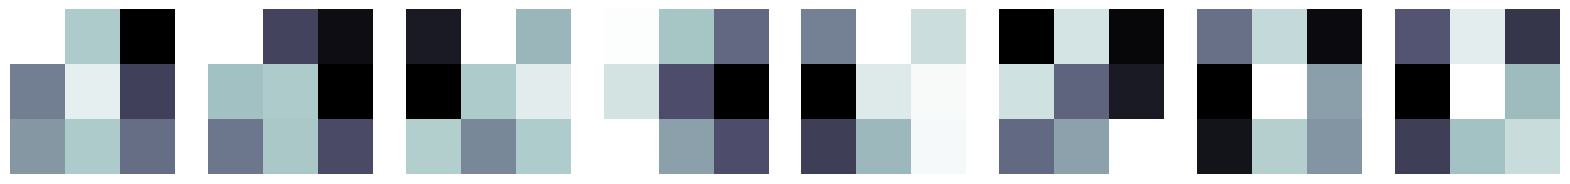

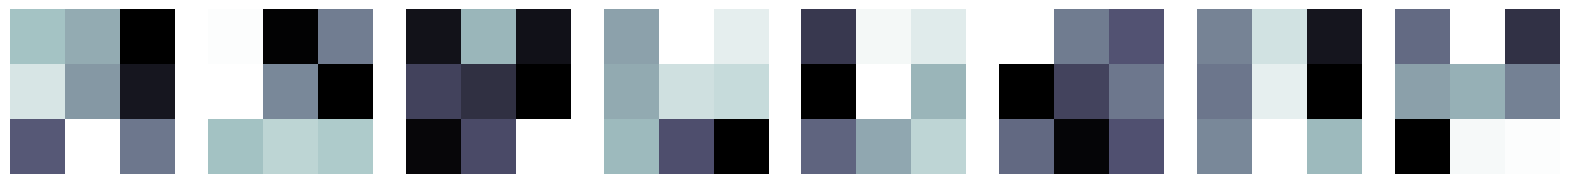

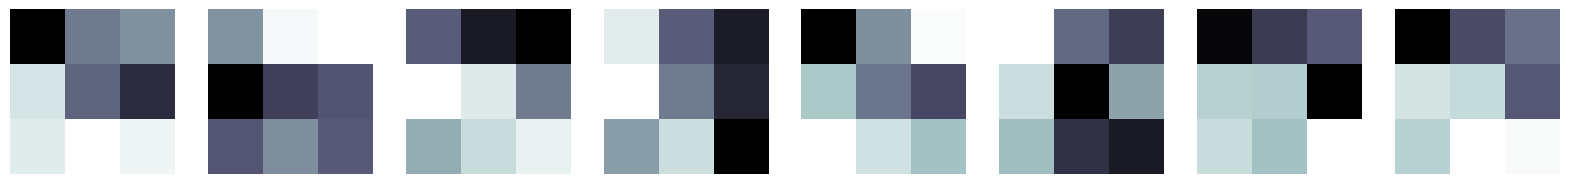

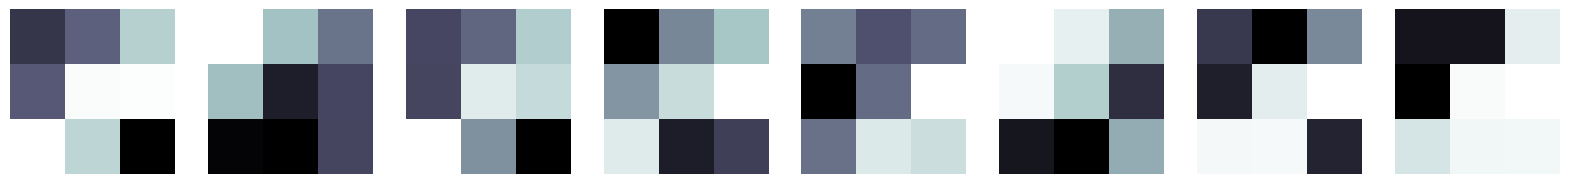

In [100]:
for i in range(len(filters2)):
    plot_filters(filters2[i])

In [130]:
def plot_images(images, ):

    rows = 5
    cols = 5

    fig = plt.figure(figsize=(10, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image = images[i]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

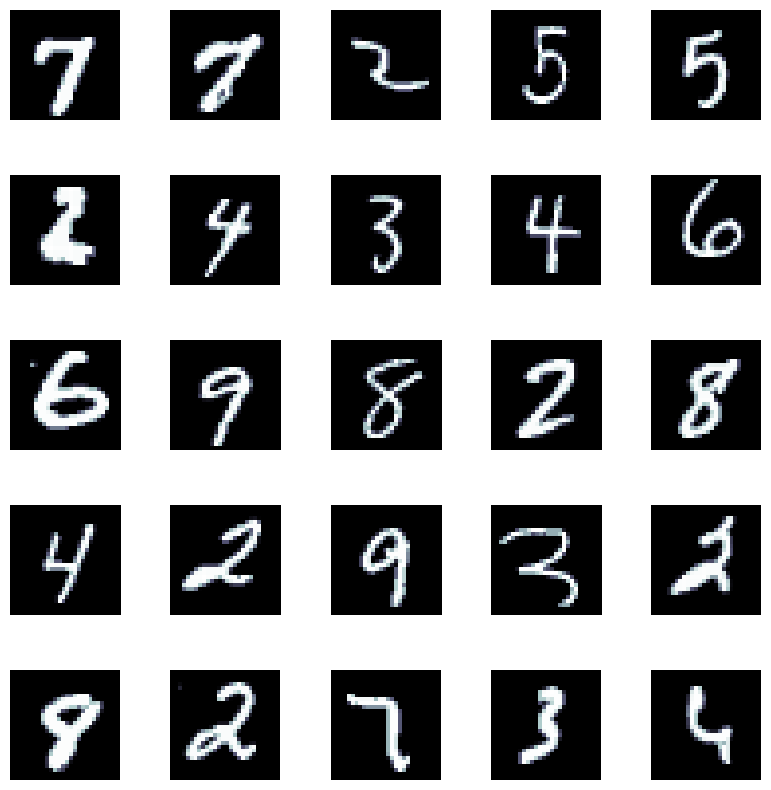

In [131]:
show_images = []

i = 0
for image, _ in train_loader:
    show_images.append(image[0])
    i += 1
    if i == 25:
        break

plot_images(show_images)

## References
Inspiration for this model came from the following:

Author: Aladdin Persson

Link: https://www.youtube.com/watch?v=wnK3uWv_WkU&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=4

Author: Greg Hogg

Link: https://www.youtube.com/watch?v=H69j69FFMV0

Author: Ben Trevett

Link: https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb